In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
import esmlab
import utils

### Look at transect from 30°S to 60°S along 180°W

In [2]:
case = 'g.e22.G1850ECO_JRA_HR.TL319_t13.004'
path = '/glade/campaign/cesm/development/bgcwg/projects/hi-res_JRA/cases/' + case + '/output/ocn/proc/tseries/month_1'
variables = ['coccoC','spC','diatC','SiO3','Fe','NO3'] # ,'TEMP','SSH','O2','ALK','SALT','NO3']
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT']

### get every 5 years 

In [3]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    ds=ds.isel(z_t_150m=0)
    return ds

In [4]:
%%time

ds_ann = xr.Dataset()

for year in [1,6,11,16,21,26,31]:
    yr4="{:02d}".format(year)
    #ds_list = []
    print(year)
    ds = xr.Dataset()

    for v in variables:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.00{yr4}01-00{yr4}12.nc'))
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                           drop_variables=["transport_components", "transport_regions"], decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))
        #ds_list.append(ds)
        

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    #print('monthly file tlen:', len(ds.time))
    ds = ds.mean(dim='time')
    #print('should be just lon and lat: ', ds.dims)
    
    ## add it to the annual file
    ds_ann = xr.concat([ds_ann, ds], "time")
    print('should grow: ', ds_ann.dims)
    #print('annual file', len(ds_ann.time))

1
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'nlat': 2400, 'nlon': 3600}))
6
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 2, 'nlat': 2400, 'nlon': 3600}))
11
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 3, 'nlat': 2400, 'nlon': 3600}))
16
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 4, 'nlat': 2400, 'nlon': 3600}))
21
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 5, 'nlat': 2400, 'nlon': 3600}))
26
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 6, 'nlat': 2400, 'nlon': 3600}))
31
coccoC
spC
diatC
SiO3
Fe
NO3
should grow:  Frozen(SortedKeysDict({'time': 7, 'nlat': 2400, 'nlon': 3600}))
CPU times: user 8min 49s, sys: 1min 4s, total: 9min 53s
Wall time: 10min 37s


In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='100GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=100GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(5) 

In [7]:
client

<Client: 'tcp://10.12.206.15:33942' processes=0 threads=0, memory=0 B>

In [8]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')

In [9]:
area = ds_grid.TAREA
lats = ds_grid.TLAT
lons = ds_grid.TLONG

ds_ann['TAREA']=ds_grid.TAREA
ds_ann['REGION_MASK']=ds_grid.REGION_MASK

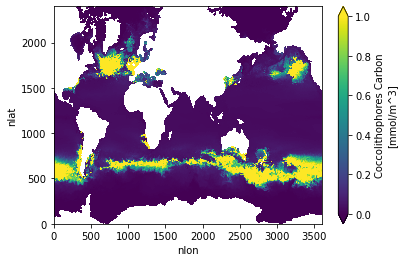

In [11]:
ds_ann.coccoC.isel(time=0).plot(vmin=0,vmax=1);

In [12]:
ds_ann['time'] = [1,6,11,16,21,26,31]

In [24]:
lon, lat, tlat = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_grid.TLAT.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
tlat = tlat[sh, :]

### Global timeseries of maps 

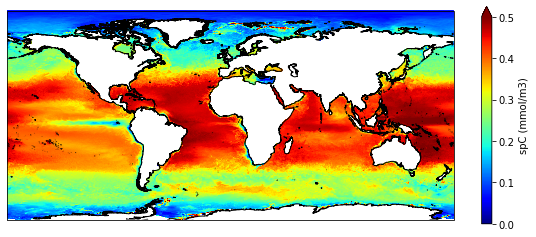

In [14]:
fig = plt.figure(figsize=(10,4))


#----------
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.spC.isel(time=0))
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=0.5, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol/m3)');

doing ts:  0
doing ts:  1
doing ts:  2
doing ts:  3
doing ts:  4
doing ts:  5
doing ts:  6


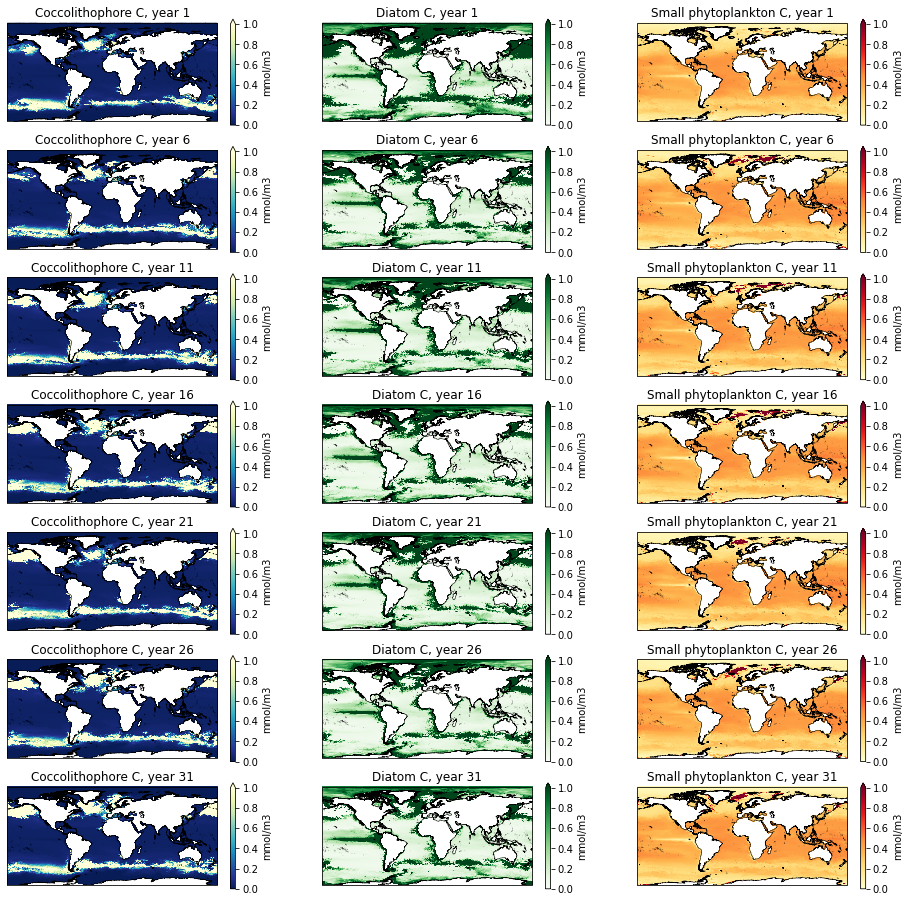

In [20]:
fig = plt.figure(figsize=(16,16))

i=1
#----------
for ts in np.arange(0,7,1):
    print('doing ts: ', ts)
    year=str(5 * ts + 1)
    
    ###########################################################################
    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.coccoC.isel(time=ts))

    ax.set_title('Coccolithophore C, year '+ year)

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='YlGnBu_r',
                     transform=ccrs.PlateCarree())

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1
    ###########################################################################

    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.diatC.isel(time=ts))

    ax.set_title('Diatom C, year '+ year)

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='Greens',
                     transform=ccrs.PlateCarree())
    
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1
    ###########################################################################

    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.spC.isel(time=ts))

    ax.set_title('Small phytoplankton C, year '+ year)

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='YlOrRd',
                     transform=ccrs.PlateCarree())

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1

### make global timeseries

In [18]:
ts_glb = utils.global_mean(ds_ann)

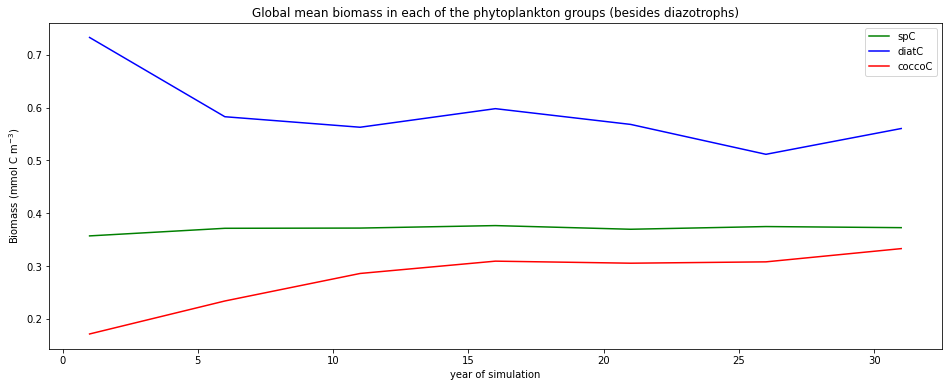

In [19]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Global mean biomass in each of the phytoplankton groups (besides diazotrophs)')
ax.plot(ts_glb['time'],ts_glb['spC'],color='green',label='spC')
ax.plot(ts_glb['time'],ts_glb['diatC'],color='blue',label='diatC')
ax.plot(ts_glb['time'],ts_glb['coccoC'],color='red',label='coccoC')

ax.set(ylabel='Biomass (mmol C m$^{-3}$)',xlabel='year of simulation')
ax.legend();

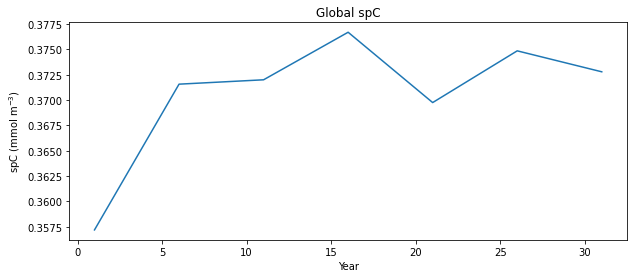

In [21]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('Global spC')
ax1.set_xlabel('Year')
ax1.set_ylabel('spC (mmol m$^{-3}$)')
ax1.plot(ts_glb['time'], ts_glb['spC']);

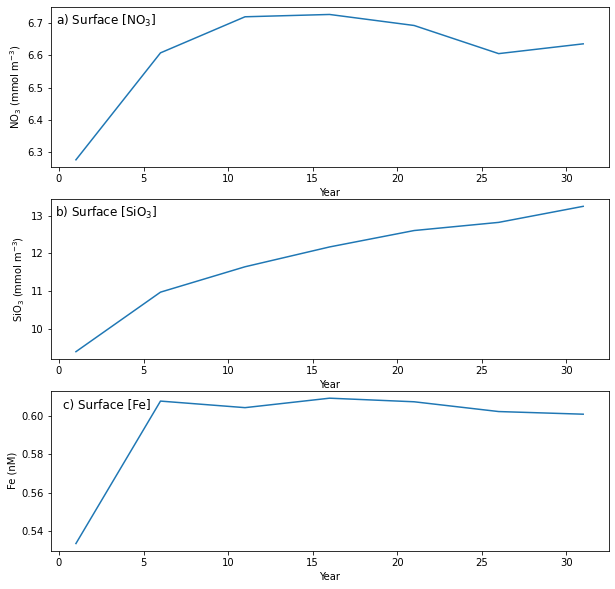

In [22]:
fig = plt.figure(figsize=(10,10))

## NO3
ax = fig.add_subplot(3,1,1)
ax.set_title('a) Surface [NO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_glb['time'], ts_glb['NO3']);

### SiO3
ax = fig.add_subplot(3,1,2)
ax.set_title('b) Surface [SiO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('SiO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_glb['time'], ts_glb['SiO3']);


### Fe
ax = fig.add_subplot(3,1,3)
ax.set_title('c) Surface [Fe]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Fe (nM)')
ax.plot(ts_glb['time'], ts_glb['Fe']*1000.);

### Southern Ocean, south of 30°S timeseries

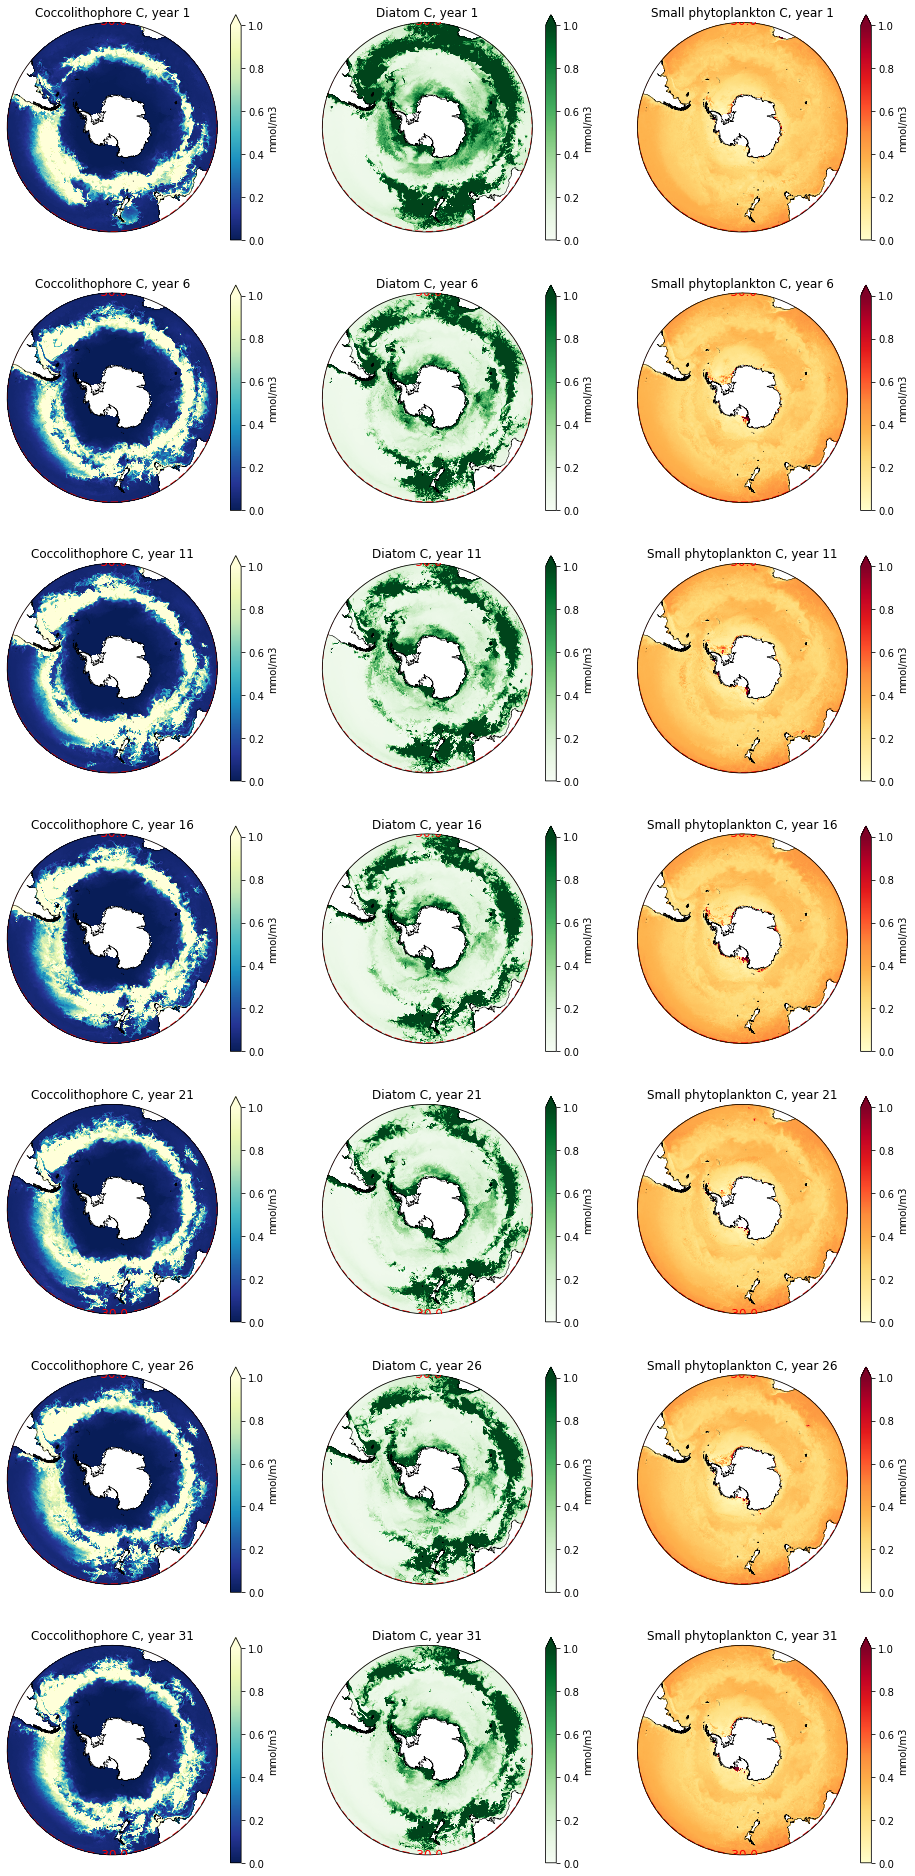

In [25]:
fig = plt.figure(figsize=(16,34))

i=1
#----------
for ts in np.arange(0,7,1):
    #print('doing ts: ', ts)
    year=str(5 * ts + 1)
    
    ###########################################################################
    ax = fig.add_subplot(7,3,i, projection=ccrs.SouthPolarStereo())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.coccoC.isel(time=ts))
    sh = lat[:, 0] < 0
    lon = lon[sh, :]
    lat = lat[sh, :]
    field = field[sh, :]

    ax.set_title('Coccolithophore C, year '+ year)
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    #################### make it a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    #################### end circle

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='YlGnBu_r',
                     transform=ccrs.PlateCarree())

    cs = ax.contour(lon,lat,tlat,
                    colors='red',
                    levels = [-30],
                    linewidths = 2,
                    transform=ccrs.PlateCarree())
    plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1
    ###########################################################################

    ax = fig.add_subplot(7,3,i, projection=ccrs.SouthPolarStereo())


    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.diatC.isel(time=ts))
    sh = lat[:, 0] < 0
    lon = lon[sh, :]
    lat = lat[sh, :]
    field = field[sh, :]

    ax.set_title('Diatom C, year '+ year)
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    #################### make it a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    #################### end circle

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='Greens',
                     transform=ccrs.PlateCarree())
    
    cs = ax.contour(lon,lat,tlat,
                    colors='red',
                    levels = [-30],
                    linewidths = 2,
                    transform=ccrs.PlateCarree())
    plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)
    
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1
    ###########################################################################

    ax = fig.add_subplot(7,3,i, projection=ccrs.SouthPolarStereo())


    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.spC.isel(time=ts))
    sh = lat[:, 0] < 0
    lon = lon[sh, :]
    lat = lat[sh, :]
    field = field[sh, :]

    ax.set_title('Small phytoplankton C, year '+ year)
    ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

    #################### make it a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    #################### end circle

    ax.coastlines('10m',linewidth=0.5)
    pc=ax.pcolormesh(lon, lat, 
                     field, vmin=0, vmax=1, 
                     cmap='YlOrRd',
                     transform=ccrs.PlateCarree())
    
    cs = ax.contour(lon,lat,tlat,
                    colors='red',
                    levels = [-30],
                    linewidths = 2,
                    transform=ccrs.PlateCarree())
    plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol/m3')
    
    i = i + 1

### Make some timeseries south of 30°S

In [ ]:
# %%time
# ts_gbc = xr.Dataset()
# for v in variables:
#     print(v)
#     mask = ds_ann[v].where(ds_grid.TLAT < -40.).where(ds_grid.TLAT >-50.)
#     ts_gbc[v] = esmlab.statistics.weighted_mean(mask, weights=area, dim=['nlat', 'nlon'])
#     ts_gbc[v].attrs = ds_ann[v].attrs

# ts_gbc = ts_gbc.compute()

##### the method above gives the exact same answer as using Matt's function (in utils.py) below

In [26]:
ds_ann_masked = ds_ann.where(ds_grid.TLAT < -30.)

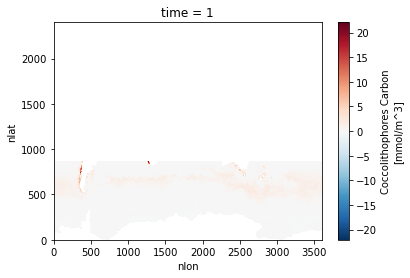

In [27]:
ds_ann_masked.coccoC.isel(time=0).plot();

In [28]:
ts_SO = utils.global_mean(ds_ann_masked)

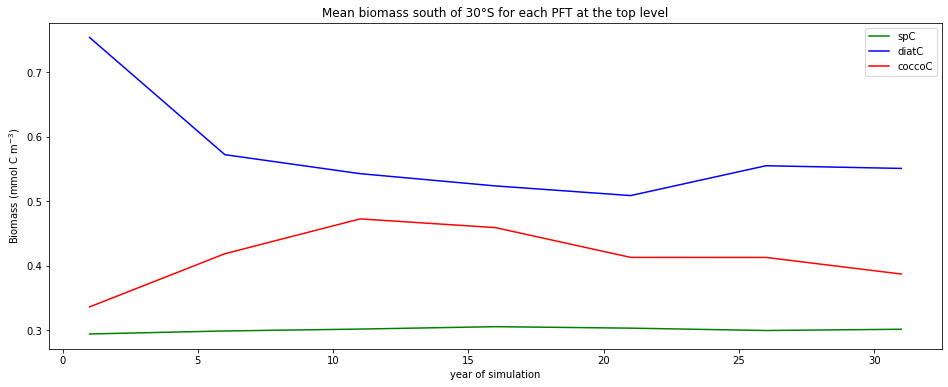

In [29]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Mean biomass south of 30°S for each PFT at the top level')
ax.plot(ts_SO['time'],ts_SO['spC'],color='green',label='spC')
ax.plot(ts_SO['time'],ts_SO['diatC'],color='blue',label='diatC')
ax.plot(ts_SO['time'],ts_SO['coccoC'],color='red',label='coccoC')

ax.set(ylabel='Biomass (mmol C m$^{-3}$)',xlabel='year of simulation')
ax.legend();

### hard to see spC in the plot above

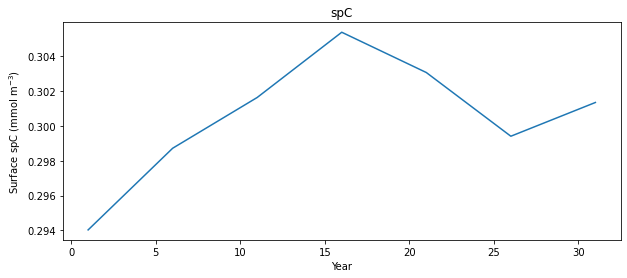

In [30]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('spC')
ax1.set_xlabel('Year')
ax1.set_ylabel('Surface spC (mmol m$^{-3}$)')
ax1.plot(ts_SO['time'], ts_SO['spC']);

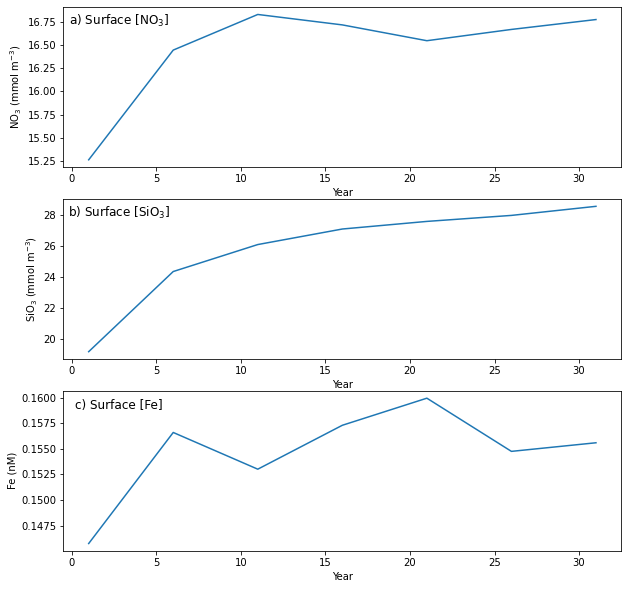

In [31]:
fig = plt.figure(figsize=(10,10))

## NO3
ax = fig.add_subplot(3,1,1)
ax.set_title('a) Surface [NO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_SO['time'], ts_SO['NO3']);

### SiO3
ax = fig.add_subplot(3,1,2)
ax.set_title('b) Surface [SiO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('SiO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_SO['time'], ts_SO['SiO3']);


### Fe
ax = fig.add_subplot(3,1,3)
ax.set_title('c) Surface [Fe]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Fe (nM)')
ax.plot(ts_SO['time'], ts_SO['Fe']*1000.);

### North Pacific region

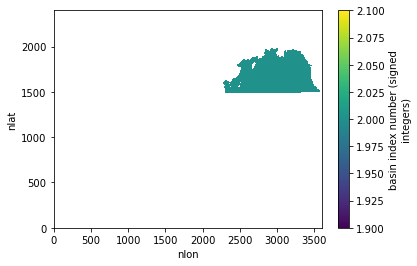

In [32]:
ds_ann.REGION_MASK.where(ds_ann.REGION_MASK == 2).where(lats > 30).plot()

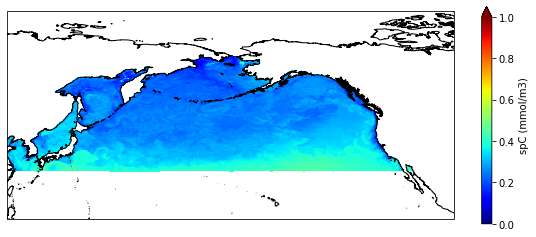

In [39]:
fig = plt.figure(figsize=(10,4))


#----------
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([120, 260, 15, 80], crs=ccrs.PlateCarree())

lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, ds_ann.spC.isel(time=0).where(ds_ann.REGION_MASK == 2).where(lats > 30))
ax.coastlines('10m',linewidth=1,zorder=1)
pc=ax.pcolormesh(lon, lat, field,
                 vmin=0, vmax=1, 
                 cmap='jet',
                 transform=ccrs.PlateCarree())

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol/m3)');

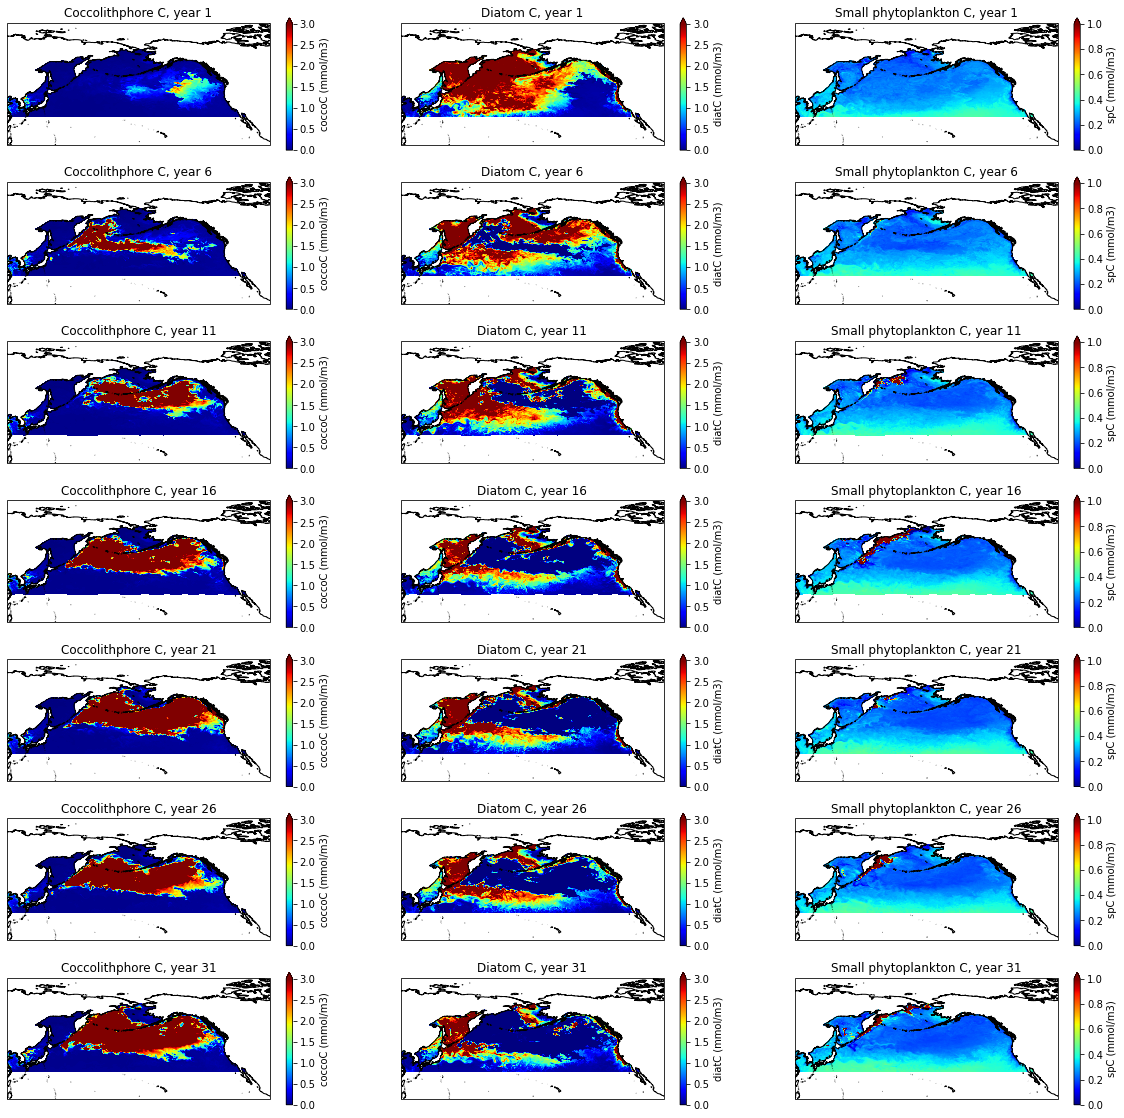

In [46]:
fig = plt.figure(figsize=(20,20))

i=1
#----------
for ts in np.arange(0,7,1):
    
    year=str(5 * ts + 1)
    
    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title('Coccolithphore C, year '+ year)
    ax.set_extent([120, 260, 15, 80], crs=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, 
                                            ds_ann.coccoC.isel(time=ts).where(ds_ann.REGION_MASK == 2).where(lats > 30))
    ax.coastlines('10m',linewidth=1,zorder=1)
    pc=ax.pcolormesh(lon, lat, field,
                     vmin=0, vmax=3, 
                     cmap='jet',
                     transform=ccrs.PlateCarree())

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol/m3)')
    
    i = i + 1
    #############################################
    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title('Diatom C, year '+ year)
    ax.set_extent([120, 260, 15, 80], crs=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, 
                                            ds_ann.diatC.isel(time=ts).where(ds_ann.REGION_MASK == 2).where(lats > 30))
    ax.coastlines('10m',linewidth=1,zorder=1)
    pc=ax.pcolormesh(lon, lat, field,
                     vmin=0, vmax=3, 
                     cmap='jet',
                     transform=ccrs.PlateCarree())

    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol/m3)');
    
    i = i + 1
    
    #############################################
    ax = fig.add_subplot(7,3,i, projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_title('Small phytoplankton C, year '+ year)
    ax.set_extent([120, 260, 15, 80], crs=ccrs.PlateCarree())

    lon, lat, field = utils.adjust_pop_grid(ds_grid.TLONG.values, ds_grid.TLAT.values, 
                                            ds_ann.spC.isel(time=ts).where(ds_ann.REGION_MASK == 2).where(lats > 30))
    ax.coastlines('10m',linewidth=1,zorder=1)
    pc=ax.pcolormesh(lon, lat, field,
                     vmin=0, vmax=1, 
                     cmap='jet',
                     transform=ccrs.PlateCarree())
    
    cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol/m3)');
    
    i = i + 1
    

### Make timeseries in the North Pacific

In [41]:
%%time
ts_npac = xr.Dataset()
for v in variables:
    print(v)
    masked = ds_ann[v].where(ds_ann.REGION_MASK == 2).where(lats > 30.)
    ts_npac[v] = esmlab.statistics.weighted_mean(masked, weights=area, dim=['nlat', 'nlon'])
    ts_npac[v].attrs = ds_ann[v].attrs

ts_npac = ts_npac.compute()

coccoC
spC
diatC
SiO3
Fe
NO3
CPU times: user 4.11 s, sys: 736 ms, total: 4.85 s
Wall time: 1min 7s


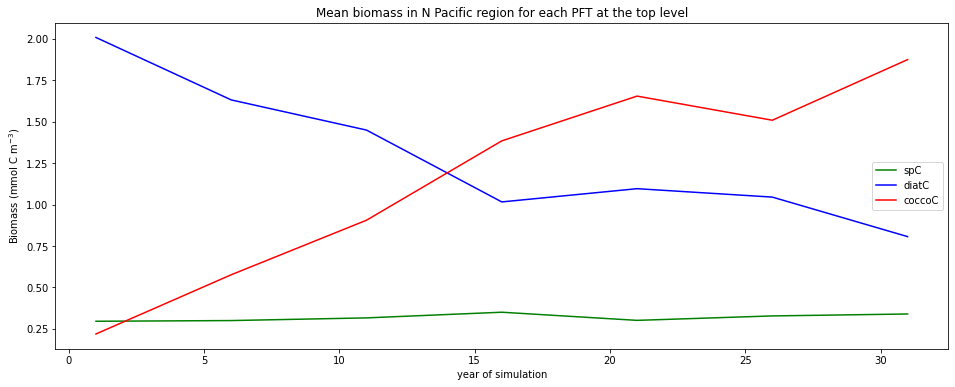

In [43]:
fig = plt.figure(figsize=(16,6))

ax = fig.add_subplot(1,1,1)
ax.set_title('Mean biomass in N Pacific region for each PFT at the top level')
ax.plot(ts_npac['time'],ts_npac['spC'],color='green',label='spC')
ax.plot(ts_npac['time'],ts_npac['diatC'],color='blue',label='diatC')
ax.plot(ts_npac['time'],ts_npac['coccoC'],color='red',label='coccoC')

ax.set(ylabel='Biomass (mmol C m$^{-3}$)',xlabel='year of simulation')
ax.legend();

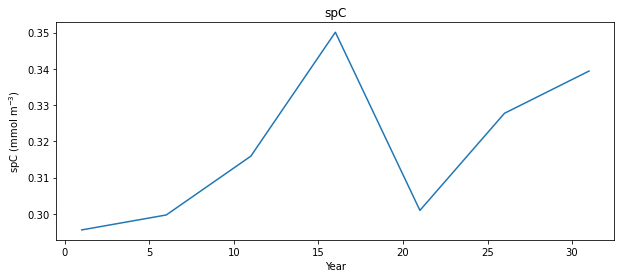

In [44]:
fig, ax1 = plt.subplots(figsize=(10,4))
plt.title('spC')
ax1.set_xlabel('Year')
ax1.set_ylabel('spC (mmol m$^{-3}$)')
ax1.plot(ts_npac['time'], ts_npac['spC']);

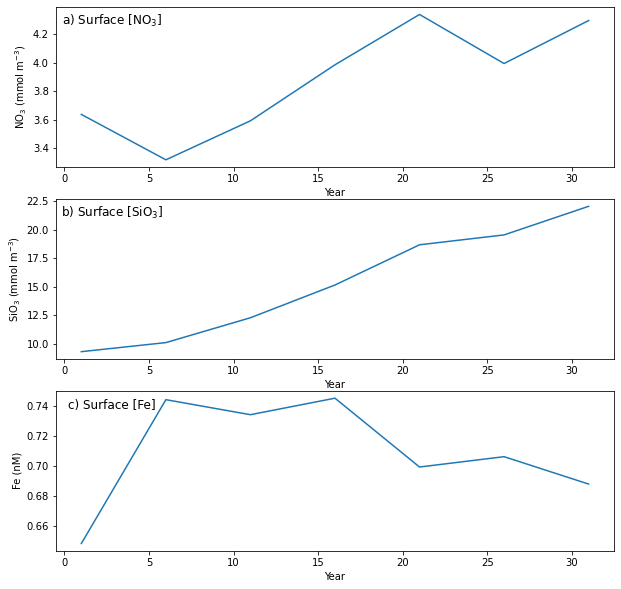

In [45]:
fig = plt.figure(figsize=(10,10))

## NO3
ax = fig.add_subplot(3,1,1)
ax.set_title('a) Surface [NO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('NO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_npac['time'], ts_npac['NO3']);

### SiO3
ax = fig.add_subplot(3,1,2)
ax.set_title('b) Surface [SiO$_3$]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('SiO$_3$ (mmol m$^{-3}$)')
ax.plot(ts_npac['time'], ts_npac['SiO3']);


### Fe
ax = fig.add_subplot(3,1,3)
ax.set_title('c) Surface [Fe]',x=0.1,y=0.85)
ax.set_xlabel('Year')
ax.set_ylabel('Fe (nM)')
ax.plot(ts_npac['time'], ts_npac['Fe']*1000.);